# Импорт данных и модулей

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
np.random.seed(100)

In [177]:
df_unchanged_train = pd.read_csv('data/train.csv')
df_unchanged_test = pd.read_csv('data/test.csv')

In [178]:
df_train = df_unchanged_train.copy()
df_test = df_unchanged_test.copy()
id_test_series = df_test['Id']
data_combined = [df_train, df_test]

replace_dict = {np.nan: 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5}
replace_columns = ['ExterQual', 'ExterCond', 'BsmtCond', 'BsmtQual', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'GarageFinish','PoolQC']

for df in data_combined:
    df.loc[:, replace_columns] = df.loc[:, replace_columns].replace(replace_dict)

replace_dict = {'N': 0, 'Y': 1}
replace_columns = ['CentralAir']

for df in data_combined:
    df.loc[:, replace_columns] = df.loc[:, replace_columns].replace(replace_dict)


df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,0,12,2008,WD,Normal,250000


# Функции для работы с данными

In [4]:
def house_data_split(df, train_size):
    return train_test_split(df.drop(['SalePrice'], axis=1), df['SalePrice'], train_size=train_size)

In [5]:
def get_grid_trainig_result(cv_results):
    result = pd.DataFrame(cv_results)
    result.sort_values(by='rank_test_score', inplace=True)
    result['mean_test_score'] = np.sqrt(-result['mean_test_score'])
    return result

In [6]:
def get_rmse(y_predicted, y_test):
    return round(np.sqrt(mean_squared_error(y_test, y_predicted)))

In [7]:
def plot_prediction_result(y_predicted, y_test):
    plt.figure(figsize=(8, 8))
    plt.scatter(y_predicted, y_test, alpha=0.5)
    min_max = [0, 500000]
    plt.plot(min_max, min_max)
    plt.xlabel('y_predicted')
    plt.ylabel('y_test')

In [8]:
def get_coefs_of_regression(regression, df):
    coeffs = dict(zip(df.columns.values, np.ravel(regression.coef_)))
    coeffs['intercept'] = regression.intercept_
    coeffs = pd.Series(coeffs).sort_values(ascending=False)
    return coeffs


# Модели на необработанных данных

## Готовим данные

In [9]:
df_model = df_train.drop(['Id'], axis=1)
df_model = df_model._get_numeric_data()
df_model.dropna(axis=0, inplace=True)

X_train, X_test, y_train, y_test = house_data_split(df_model, 0.8)



## Ridge

In [10]:
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('estimator', linear_model.Ridge())])
ridge_parameters = {'estimator__alpha': [0.05, 0.5, 1, 2, 4, 8, 16, 40, 80, 100],
                      'estimator__fit_intercept': [True, False]}
ridge_grid = GridSearchCV(ridge_pipe, ridge_parameters,
                          cv=10, scoring='neg_mean_squared_error')

In [11]:
ridge_grid.fit(X_train, y_train)
get_grid_trainig_result(ridge_grid.cv_results_)[['param_estimator__alpha', 'param_estimator__fit_intercept','mean_test_score']]

,param_estimator__alpha,param_estimator__fit_intercept,mean_test_score
18,100,True,38779.490226
16,80,True,39127.906275
14,40,True,40253.934373
12,16,True,41633.787847
10,8,True,42429.845364
8,4,True,42967.789224
6,2,True,43291.699323
4,1,True,43471.722447
2,0.5,True,43567.002887
0,0.05,True,43656.047856


RMSE on test data: 57080


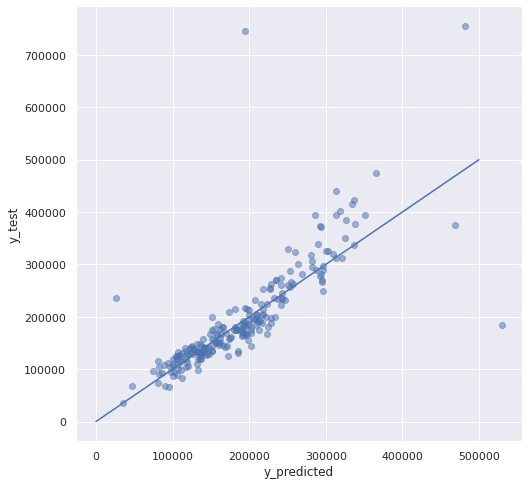

In [12]:
predicted = ridge_grid.predict(X_test)
print(f'RMSE on test data: {get_rmse(predicted, y_test)}')
plot_prediction_result(predicted, y_test)

In [13]:
get_coefs_of_regression(ridge_grid.best_estimator_['estimator'], df_model).sort_values(ascending=False)

intercept        183049.229911
OverallQual       14437.585308
ExterQual          9720.700453
GrLivArea          8499.696164
TotRmsAbvGrd       7807.655609
MasVnrArea         7337.938060
GarageCars         6950.658208
BsmtQual           6664.174632
KitchenQual        6260.492383
LotArea            6224.438712
1stFlrSF           6078.748528
OverallCond        4960.071164
BsmtFinSF1         4950.727980
2ndFlrSF           4647.918941
FullBath           4077.798304
BsmtFullBath       3717.931493
PoolArea           3668.338054
TotalBsmtSF        3640.347802
YearBuilt          3105.950248
ScreenPorch        2465.752324
WoodDeckSF         2159.284557
GarageArea         2141.827146
Fireplaces         1840.453405
FireplaceQu        1829.004211
3SsnPorch          1806.455280
MoSold             1630.521129
GarageQual         1299.113944
HalfBath           1190.384063
CentralAir         1003.053103
YearRemodAdd        989.537986
OpenPorchSF         889.055784
HeatingQC           527.570234
BsmtFinS

## Lasso

In [14]:
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('estimator', linear_model.Lasso())])
# используем такие большие параметры, потому что при меньших модель дает плохой результат и не сходится
lasso_parameters = {'estimator__alpha': [100, 500, 2000, 4000],
                    'estimator__fit_intercept': [True, False]}
lasso_grid = GridSearchCV(lasso_pipe, lasso_parameters,
                          cv=10, scoring='neg_mean_squared_error')

In [15]:
lasso_grid.fit(X_train, y_train)
result = lasso_grid.cv_results_
get_grid_trainig_result(result)[['param_estimator__alpha', 'param_estimator__fit_intercept','mean_test_score']]

,param_estimator__alpha,param_estimator__fit_intercept,mean_test_score
6,4000,True,38686.066034
4,2000,True,39003.894106
2,500,True,41253.361438
0,100,True,42899.223021
7,4000,False,187100.272691
5,2000,False,187183.134301
3,500,False,187699.588660
1,100,False,187886.246438


RMSE on test data: 51054


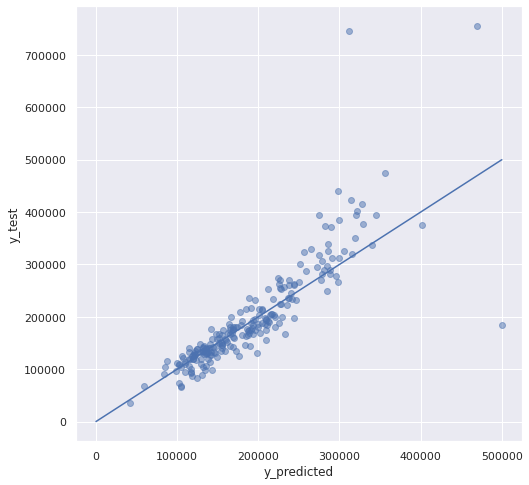

In [16]:
predicted = lasso_grid.predict(X_test)
print(f'RMSE on test data: {get_rmse(predicted, y_test)}')
plot_prediction_result(predicted, y_test)

In [17]:
coefs = get_coefs_of_regression(lasso_grid.best_estimator_['estimator'], df_model)
mask = (coefs > -1) & (coefs < 1)
coefs[mask]

OpenPorchSF      0.0
EnclosedPorch   -0.0
GarageCond       0.0
GarageQual       0.0
YrSold          -0.0
ScreenPorch      0.0
GarageArea       0.0
PoolArea        -0.0
GarageYrBlt      0.0
MiscVal          0.0
MoSold           0.0
3SsnPorch        0.0
FullBath         0.0
TotalBsmtSF      0.0
YearBuilt        0.0
HalfBath         0.0
LotFrontage      0.0
BsmtHalfBath    -0.0
LowQualFinSF    -0.0
2ndFlrSF         0.0
CentralAir       0.0
HeatingQC        0.0
BedroomAbvGr     0.0
BsmtUnfSF       -0.0
BsmtFinSF2       0.0
BsmtCond         0.0
OverallCond      0.0
ExterCond        0.0
dtype: float64

Вывод: лассо крайне плохо работает на наших данных(слишком много фич)
Также он посчитал ненужными слудающие фичи:
1. TotalBsmtSf
2. BSNT cond
3. YearBuit
4. HeatingQC
5. CentralAir

Это нам, к сожалению ничего не дает, потому что фичи хороши

In [18]:
r = RandomForestRegressor()
r.fit(X_train, y_train)
y_predicted = r.predict(X_test)

41834


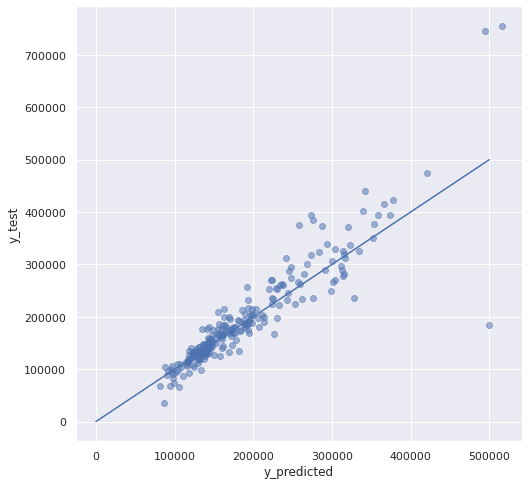

In [19]:
print(get_rmse(y_predicted, y_test))
plot_prediction_result(y_predicted, y_test)

## SVM

# Беглый анализ фич и первые графики

Данный шаг идет первым, так как в наших данных слишком много фич и явно будут сильно коррелирующие или бесполезные, поэтому такая очистка позволит качественнее проводить дальнейший анализ на уменьшенной выборке

### LotArea

In [28]:
df_train[['LotArea', 'SalePrice', 'GrLivArea']].corr()

,LotArea,SalePrice,GrLivArea
LotArea,1.000000,0.263843,0.263116
SalePrice,0.263843,1.000000,0.708624
GrLivArea,0.263116,0.708624,1.000000


/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

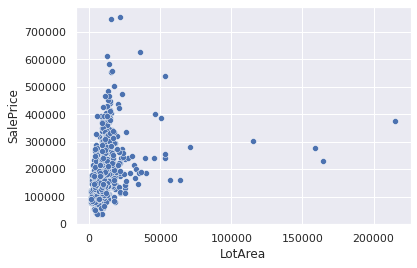

In [29]:
sns.scatterplot(df_train['LotArea'], df_train['SalePrice'])

Вывод: откидываем LotArea

### Utilities

In [14]:
df_train.groupby('Utilities')['Id'].nunique()

Utilities
AllPub    1459
NoSeWa       1
Name: Id, dtype: int64

Вывод: отбрость

 ### MSZoning

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

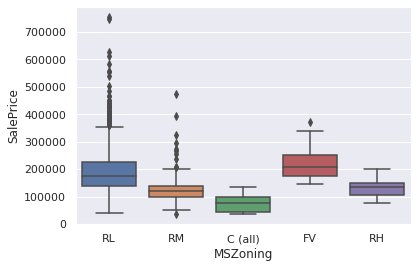

In [15]:
sns.boxplot(data=df_train, x='MSZoning', y='SalePrice')

Вывод: Будет коррелировать с районом, поэтому стоит отбросить данную переменную и заняться дальнейшим изучение районов

### LotFrontage

In [20]:
df_train[['LotFrontage','LotShape', 'SalePrice']].corr()

,LotFrontage,SalePrice
LotFrontage,1.000000,0.351799
SalePrice,0.351799,1.000000


/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

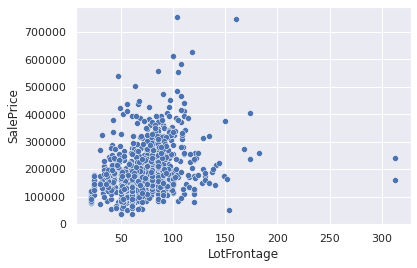

In [21]:
sns.scatterplot(df_train['LotFrontage'], df_train['SalePrice'])

Вывод: слишком слабая корреляция, отбрасываем

###  Street/Alley

<AxesSubplot:xlabel='Street', ylabel='SalePrice'>

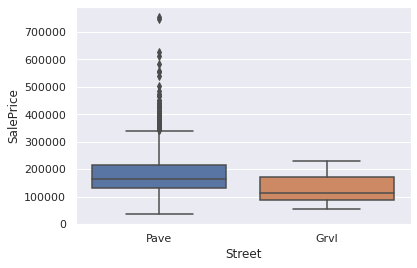

In [22]:
sns.boxplot(data=df_train, x='Street', y='SalePrice')

<AxesSubplot:xlabel='Alley', ylabel='SalePrice'>

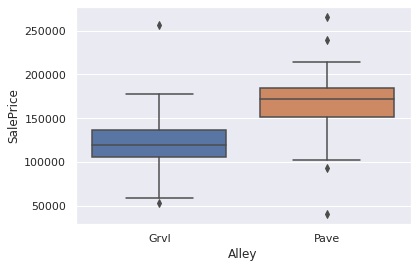

In [23]:
sns.boxplot(data=df_train, x='Alley', y='SalePrice')

Вывод: отбрасываем

### LandCOntour

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

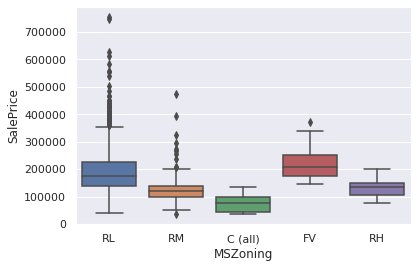

In [20]:
sns.boxplot(data=df_train, x='MSZoning', y='SalePrice')

<AxesSubplot:xlabel='LandContour', ylabel='SalePrice'>

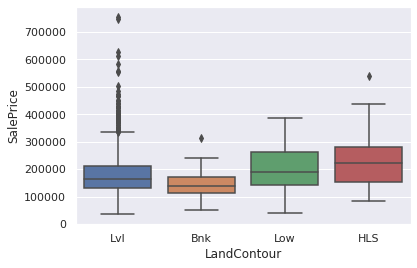

In [21]:
sns.boxplot(data=df_train, x='LandContour', y='SalePrice')

<AxesSubplot:xlabel='LandSlope', ylabel='SalePrice'>

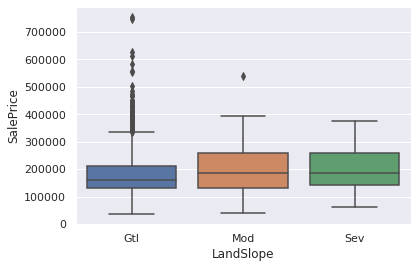

In [22]:
sns.boxplot(data=df_train, x='LandSlope', y='SalePrice')

Вывод:  LandContour и LandSLope можно отбросить

### LotConfig

<AxesSubplot:xlabel='LotConfig', ylabel='SalePrice'>

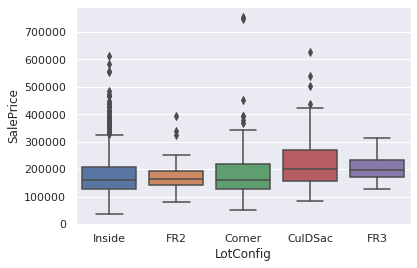

In [23]:
sns.boxplot(data=df_train, x='LotConfig', y='SalePrice')

### Neighbourhood

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

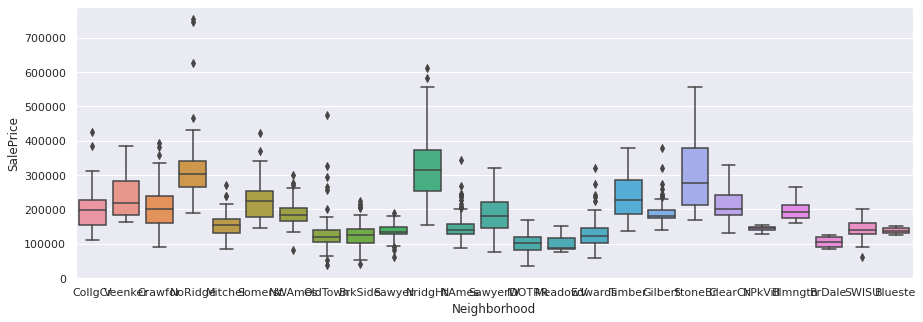

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.boxplot(data=df_train, x='Neighborhood', y='SalePrice')

<AxesSubplot:xlabel='Neighborhood', ylabel='count'>

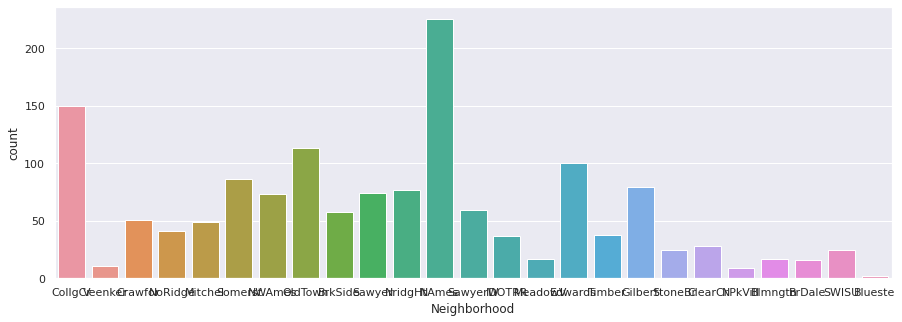

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.countplot(data=df_train, x='Neighborhood')

Вывод: эту фичу точно стоит оставить, но стоит попробовать переделать ее в криминальность района, потому что слишком много категорий

### Overall

In [26]:
df_train[['OverallCond', 'OverallQual', 'SalePrice']].corr()

,OverallCond,OverallQual,SalePrice
OverallCond,1.000000,-0.091932,-0.077856
OverallQual,-0.091932,1.000000,0.790982
SalePrice,-0.077856,0.790982,1.000000


<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

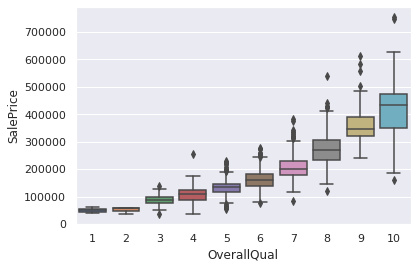

In [27]:
sns.boxplot(data=df_train, x='OverallQual', y='SalePrice')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

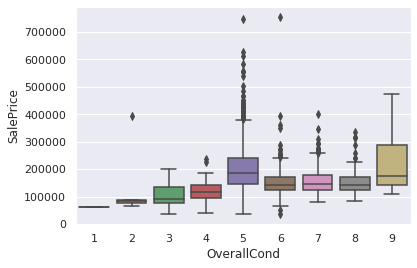

In [28]:
sns.boxplot(data=df_train, x='OverallCond', y='SalePrice')

In [29]:
df_train['temp'] = df_train['OverallQual'] + df_train['OverallCond']

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

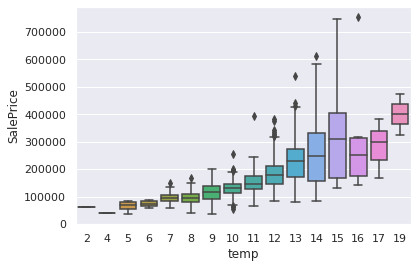

In [30]:
sns.boxplot(data=df_train, x='temp', y='SalePrice')

<AxesSubplot:xlabel='OverallCond', ylabel='SalePrice'>

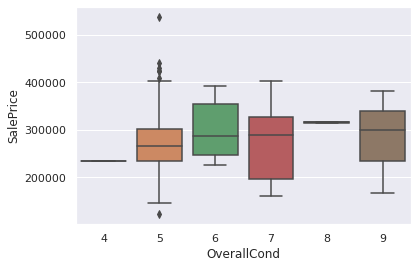

In [31]:
qual = df_train['OverallQual']
cond = df_train['OverallCond']
mask = (qual == 8)
sns.boxplot(data=df_train[mask], x='OverallCond', y='SalePrice')

Вывод: OverallCond можно отбросить, он не дает полезной информации

### YearBuilt

In [32]:
df_train[['YearBuilt','YearRemodAdd' ,'SalePrice']].corr()

,YearBuilt,YearRemodAdd,SalePrice
YearBuilt,1.000000,0.592855,0.522897
YearRemodAdd,0.592855,1.000000,0.507101
SalePrice,0.522897,0.507101,1.000000


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

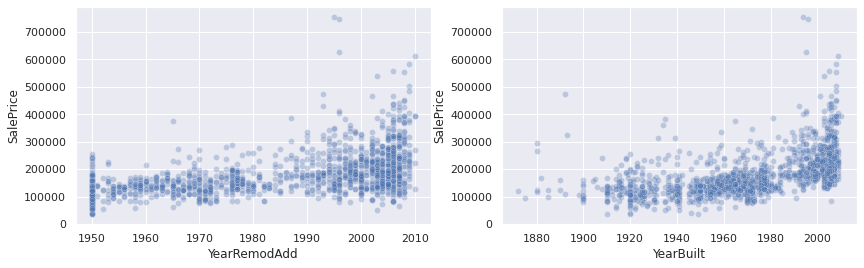

In [33]:
fig, axis = plt.subplots(1, 2, figsize=(14, 4))
sns.scatterplot(data=df_train, x='YearRemodAdd', y='SalePrice', alpha=0.3, ax=axis[0])
sns.scatterplot(data=df_train, x='YearBuilt', y='SalePrice', alpha=0.3, ax=axis[1])

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

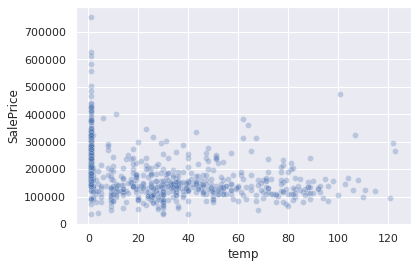

In [34]:
df_train['temp'] = df_train['YearRemodAdd'] - df_train['YearBuilt']
mask = df_train['temp'] > 0
sns.scatterplot(data=df_train[mask], x='temp', y='SalePrice', alpha=0.3)

Вывод: год кап.ремонта можно отбросить, т.к. он содержит меньше информации чем год постройки дома

### RoofMatl

In [35]:
df_train.groupby('RoofMatl')['Id'].nunique()

RoofMatl
ClyTile       1
CompShg    1434
Membran       1
Metal         1
Roll          1
Tar&Grv      11
WdShake       5
WdShngl       6
Name: Id, dtype: int64

Вывод: может отбросить, так как слишком мало типов крыш

### MasVnr

In [36]:
df_train['temp']

0        0
1        0
2        1
3       55
4        0
        ..
1455     1
1456    10
1457    65
1458    46
1459     0
Name: temp, Length: 1460, dtype: int64

In [37]:
df_train.isnull()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,temp
0,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1456,False,False,False,False,False,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,False
1457,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1458,False,False,False,False,False,False,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False


In [38]:
df_train['temp'] = df_train['MasVnrArea'].isnull()
df_train[['MasVnrArea', 'temp', 'SalePrice']].corr()

,MasVnrArea,temp,SalePrice
MasVnrArea,1.000000,NaN,0.477493
temp,NaN,1.000000,0.051933
SalePrice,0.477493,0.051933,1.000000


<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

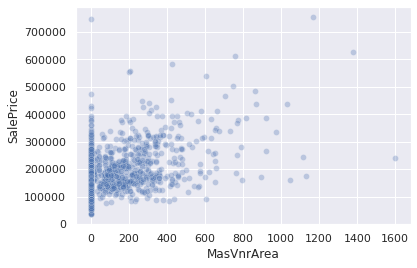

In [39]:
sns.scatterplot(data=df_train, x='MasVnrArea', y='SalePrice', alpha=0.3)

<AxesSubplot:xlabel='MasVnrType', ylabel='SalePrice'>

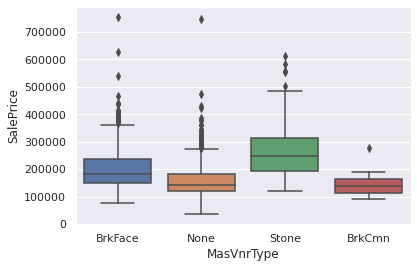

In [40]:
sns.boxplot(data=df_train, x='MasVnrType', y='SalePrice')

Вывод: откидываем MasVnrArea

### Exterior

In [41]:
df_train['temp'] = df_train['ExterCond'] + df_train['ExterQual']
df_train[['ExterQual', 'ExterCond', 'temp', 'SalePrice']].corr()

,ExterQual,ExterCond,temp,SalePrice
ExterQual,1.000000,0.009184,0.854517,0.682639
ExterCond,0.009184,1.000000,0.527249,0.018899
temp,0.854517,0.527249,1.000000,0.589888
SalePrice,0.682639,0.018899,0.589888,1.000000


<AxesSubplot:xlabel='ExterCond', ylabel='SalePrice'>

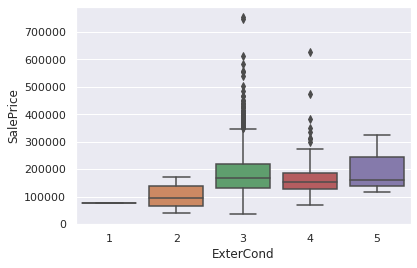

In [42]:
sns.boxplot(data=df_train, x='ExterCond', y='SalePrice')

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

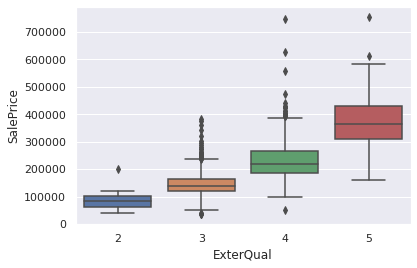

In [43]:
sns.boxplot(data=df_train, x='ExterQual', y='SalePrice')

Стоит попробовать объединить 2 эти фичи

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

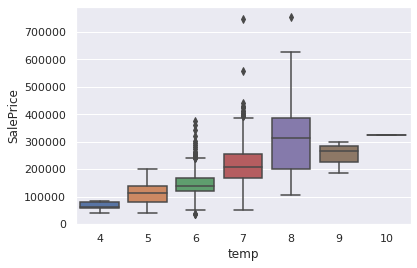

In [44]:
sns.boxplot(data=df_train, x='temp', y='SalePrice')

<AxesSubplot:xlabel='ExterQual', ylabel='SalePrice'>

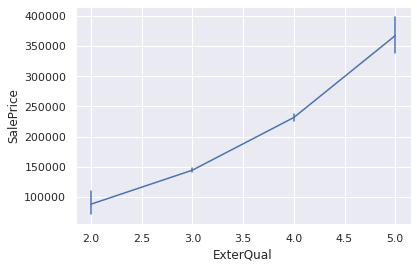

In [45]:
sns.lineplot(data=df_train, x="ExterQual", y="SalePrice",
             err_style="bars", ci=95)

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

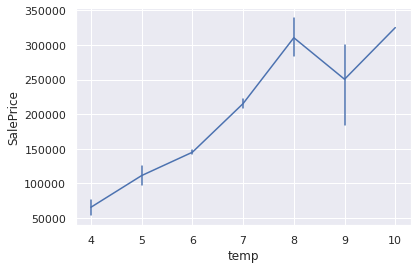

In [46]:
sns.lineplot(data=df_train, x="temp", y="SalePrice",
             err_style="bars", ci=95)

Вывод: ExterQual дает результат лучше, чем ExterCond и их объединение

### Foundation

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

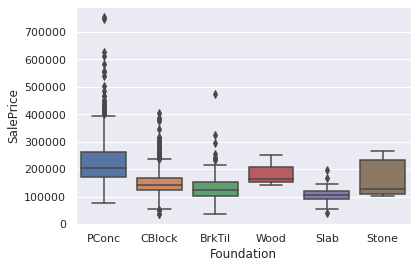

In [47]:
sns.boxplot(data=df_train, x='Foundation', y='SalePrice')

Вывод: отбрасываем, так как несущественно влияет

### Bsmt

Хотелось бы как-то отличать людей с гаражом и без, поделив их на 2 категории

In [48]:
df_train['temp'] = df_train['BsmtQual'] + df_train['BsmtCond']

In [49]:
df_train[['BsmtQual', 'BsmtCond', 'temp', 'SalePrice']].corr()

,BsmtQual,BsmtCond,temp,SalePrice
BsmtQual,1.000000,0.633713,0.944362,0.585207
BsmtCond,0.633713,1.000000,0.852887,0.212607
temp,0.944362,0.852887,1.000000,0.485364
SalePrice,0.585207,0.212607,0.485364,1.000000


<AxesSubplot:xlabel='BsmtCond', ylabel='SalePrice'>

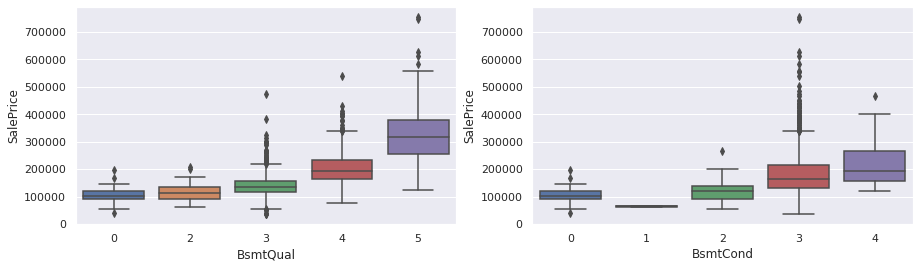

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.boxplot(data=df_train, x='BsmtQual', y='SalePrice', ax=axes[0])
sns.boxplot(data=df_train, x='BsmtCond', y='SalePrice', ax=axes[1])

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

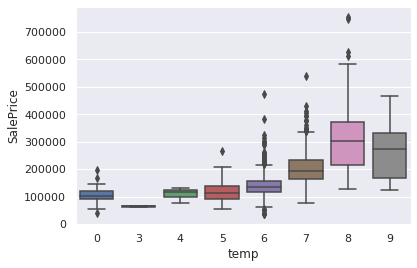

In [51]:
df_train['temp'] = df_train['BsmtQual'] + df_train['BsmtCond']
sns.boxplot(data=df_train, x='temp', y='SalePrice')

Вывод: определенно стоит оставить качество гаража в качестве фичи

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

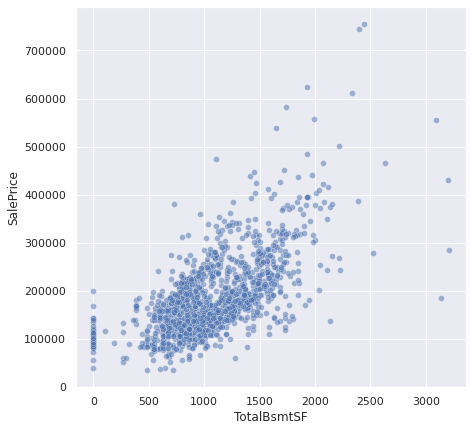

In [53]:
wihtout_outlier = df_train[df_train['TotalBsmtSF'] < 5000]
plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(data=wihtout_outlier, x='TotalBsmtSF', y='SalePrice', alpha=0.5)

Вывод: Оставляем площадь гаража

### Central air /  heating

<AxesSubplot:xlabel='CentralAir', ylabel='SalePrice'>

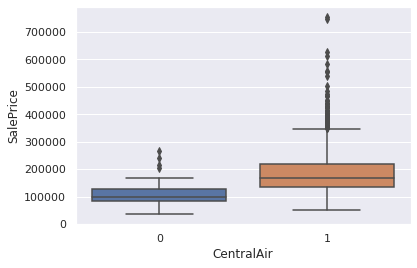

In [54]:
sns.boxplot(data=df_train, x='CentralAir', y='SalePrice')

Определенно оставляем

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

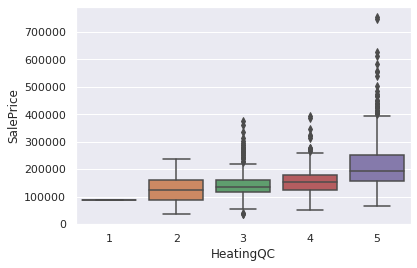

In [55]:
sns.boxplot(data=df_train, x='HeatingQC', y='SalePrice')

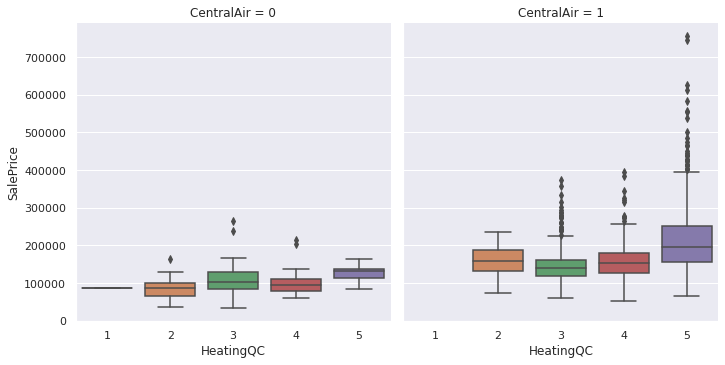

In [56]:
sns.catplot(
    data=df_train, x='HeatingQC', y='SalePrice',
    col='CentralAir', kind='box')

Оставим только CentralAir

### SF(Квадратные метры дома)

(array([4., 3., 1., 2., 0., 2., 5., 1., 6., 2.]),
 array([ 53. , 104.9, 156.8, 208.7, 260.6, 312.5, 364.4, 416.3, 468.2,
        520.1, 572. ]),
 <BarContainer object of 10 artists>)

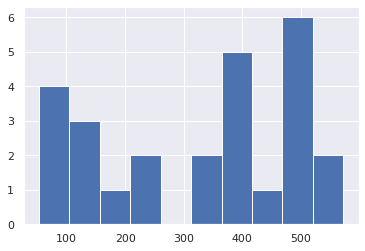

In [57]:
diff = df_train['GrLivArea'] - (df_train['1stFlrSF'] + df_train['2ndFlrSF'])
diff = diff[diff > 0]
plt.hist(diff)

In [58]:
mask = df_train['LowQualFinSF'] > 0
df_train['LowQualFinSF'][mask] == diff

51      True
88      True
125     True
170     True
185     True
187     True
197     True
198     True
263     True
267     True
406     True
589     True
635     True
729     True
829     True
831     True
868     True
873     True
883     True
945     True
1009    True
1031    True
1173    True
1349    True
1364    True
1440    True
dtype: bool

Получается, что LowQualFinSF - это количество недоделанной части дома, поэтому оставим фичу df_train['1stFlrSF'] + df_train['2ndFlrSF'], отвечающую за квадратные метры всего

### Количество full/half bathrooms, bedrooms, kitchen и комнат всего

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

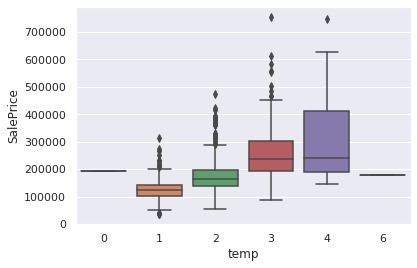

In [59]:
df_train['temp'] = df_train['BsmtFullBath'] + df_train['FullBath']
sns.boxplot(data=df_train, x='temp', y='SalePrice')

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

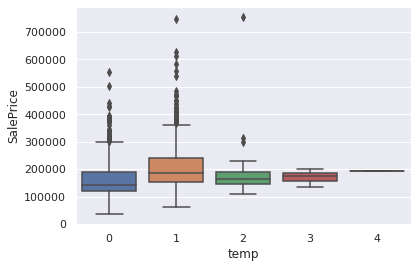

In [60]:
df_train['temp'] = df_train['BsmtHalfBath'] + df_train['HalfBath']
sns.boxplot(data=df_train, x='temp', y='SalePrice')

<AxesSubplot:xlabel='temp', ylabel='SalePrice'>

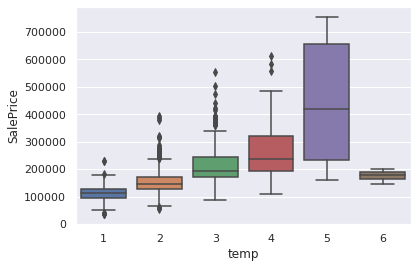

In [61]:
df_train['temp'] = df_train['BsmtHalfBath'] + df_train['HalfBath'] + df_train['BsmtFullBath'] + df_train['FullBath']
sns.boxplot(data=df_train, x='temp', y='SalePrice')

In [62]:
sm = df_train['temp']
feets = df_train['1stFlrSF'] + df_train['2ndFlrSF']
sm.corr(feets)

0.6266400981665609

In [63]:
sm += df_train['BedroomAbvGr']
sm.corr(feets)

0.7209258325720446

In [64]:
sm += df_train['KitchenAbvGr']
sm.corr(feets)

0.7142167798435548

<AxesSubplot:ylabel='SalePrice'>

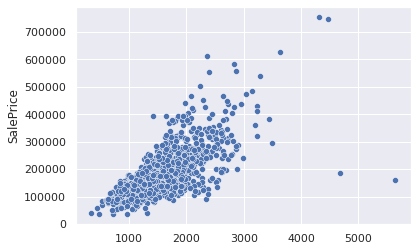

In [65]:
sns.scatterplot(x=feets, y=df_train['SalePrice'])

Вывод: можно отбросить как спальни, так и ванные комнаты, потому что они очевидно коррелируют с площадью дома, тем самым дают лишнюю информацию

ОТБРАСЫВАЕМ ВСЕ КОМНАТЫ.

### Качество kitchen

In [24]:
df_train[['KitchenQual', 'SalePrice']].corr()

,KitchenQual,SalePrice
KitchenQual,1.0000,0.6596
SalePrice,0.6596,1.0000


<AxesSubplot:xlabel='KitchenQual', ylabel='SalePrice'>

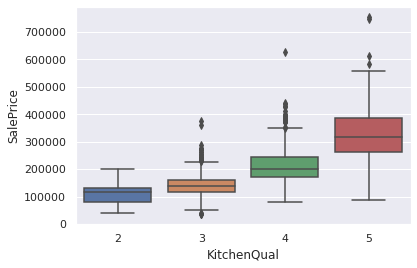

In [66]:
sns.boxplot(data=df_train, x='KitchenQual', y='SalePrice')

### Functional(общее состояние дома)

<AxesSubplot:xlabel='Functional', ylabel='SalePrice'>

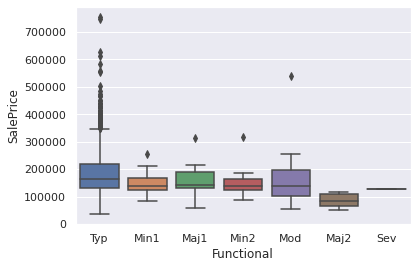

In [67]:
sns.boxplot(data=df_train, x='Functional', y='SalePrice')

Вывод: отбросить Functional

### Fireplace

In [68]:
df_train['Fireplaces']

0       0
1       1
2       1
3       1
4       1
       ..
1455    1
1456    2
1457    2
1458    0
1459    0
Name: Fireplaces, Length: 1460, dtype: int64

<AxesSubplot:xlabel='Fireplaces', ylabel='Count'>

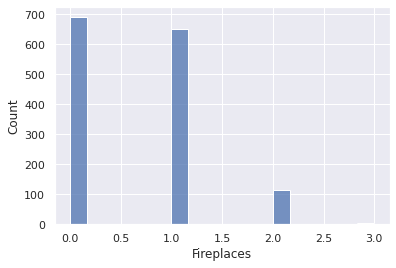

In [69]:
sns.histplot(df_train['Fireplaces'])

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

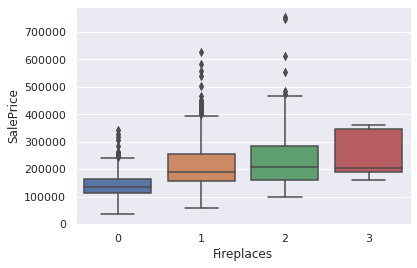

In [70]:
 sns.boxplot(x=df_train['Fireplaces'], y=df_train['SalePrice'])

<AxesSubplot:xlabel='FireplaceQu', ylabel='SalePrice'>

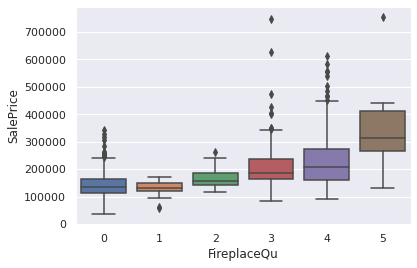

In [71]:
 sns.boxplot(x=df_train['FireplaceQu'], y=df_train['SalePrice'])

<AxesSubplot:xlabel='FireplaceQu', ylabel='Count'>

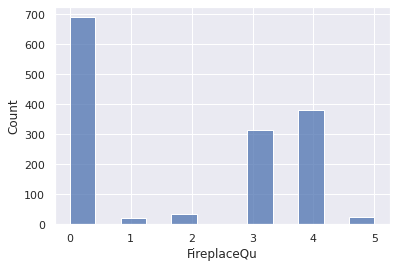

In [72]:
 sns.histplot(x=df_train['FireplaceQu'])

Отбрасываем Fireplaces и оставляем только FireplaceQu

### Garage

In [73]:
df_train[['GarageArea', 'GarageCars', 'GarageFinish']].corr()

,GarageArea,GarageCars
GarageArea,1.000000,0.882475
GarageCars,0.882475,1.000000


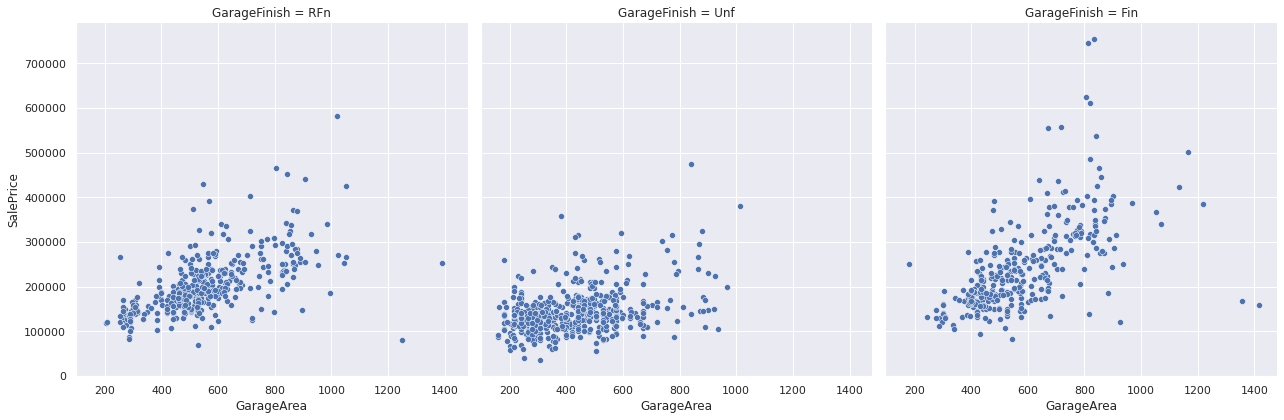

In [74]:
g = sns.FacetGrid(df_train, col='GarageFinish', col_wrap=3, height=6)
g.map(sns.scatterplot,  'GarageArea', 'SalePrice')

Можем заметить, что в зависимости от законченности гаража сильно возростает корреляция площади  и цены

In [75]:
df_train[['GarageCond', 'GarageQual','GarageArea', 'SalePrice']].corr()

,GarageCond,GarageQual,GarageArea,SalePrice
GarageCond,1.000000,0.959172,0.547259,0.263191
GarageQual,0.959172,1.000000,0.558938,0.273839
GarageArea,0.547259,0.558938,1.000000,0.623431
SalePrice,0.263191,0.273839,0.623431,1.000000


Вывод: откидываем GarageCond и GarageQual. Оставляем GarageArea и GarageFinish, чтобы потом из них собрать одну компаундную фичу

### Porch

In [76]:
porchs = ['WoodDeckSF','OpenPorchSF', 'ScreenPorch', 'EnclosedPorch']
porch_area = df_train[porchs].sum(axis=1)

/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='SalePrice'>

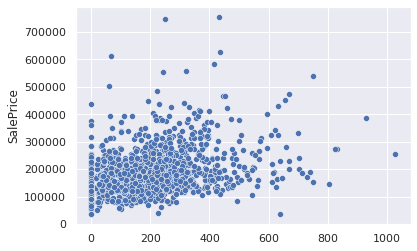

In [77]:
sns.scatterplot(porch_area, df_train['SalePrice'])

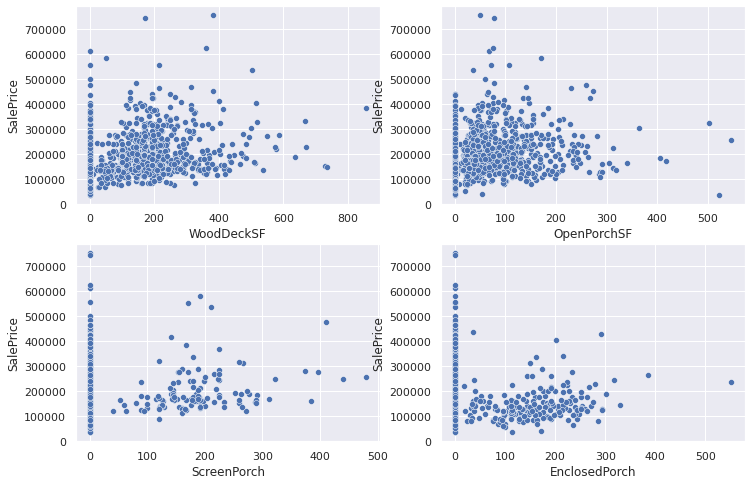

In [78]:
fig, axis = plt.subplots(2, 2, figsize=(12, 8))
axis = np.ravel(axis)
for ax, porch in zip(axis, porchs):
    sns.scatterplot(data=df_train, x=porch, y='SalePrice', ax=ax)

Отбрасываем Porch

### Pool

In [79]:
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,temp
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,2,2008,WD,Normal,208500,8
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,5,2007,WD,Normal,181500,7
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,9,2008,WD,Normal,223500,8
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,2,2006,WD,Abnorml,140000,6
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,0,12,2008,WD,Normal,250000,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,8,2007,WD,Normal,175000,7
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,MnPrv,NaN,0,2,2010,WD,Normal,210000,7
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,GdPrv,Shed,2500,5,2010,WD,Normal,266500,7
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,0,4,2010,WD,Normal,142125,5


<AxesSubplot:xlabel='PoolArea', ylabel='Count'>

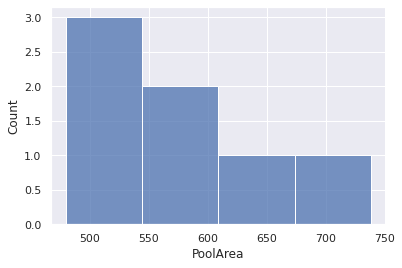

In [80]:
mask = df_train['PoolArea'] > 0
sns.histplot(data=df_train[mask], x='PoolArea')

Вывод: фичи связанные с бассейном надо отбросить т.к. их слишком мало и они не будут влиять на результата

### misc

In [81]:
df_train[['SalePrice', 'MiscVal']].corr()

,SalePrice,MiscVal
SalePrice,1.00000,-0.02119
MiscVal,-0.02119,1.00000


In [82]:
mask = df_train['MiscVal'] > 0
df_train.loc[mask, ['SalePrice', 'MiscVal']].corr()

,SalePrice,MiscVal
SalePrice,1.000000,0.088963
MiscVal,0.088963,1.000000


<AxesSubplot:xlabel='MiscVal', ylabel='Count'>

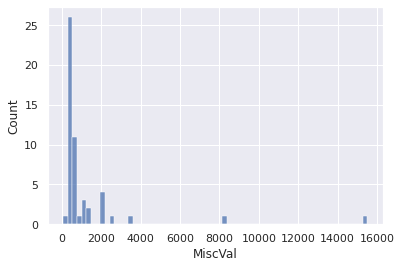

In [83]:
sns.histplot(df_train[mask], x='MiscVal')

Вывод: мы можем отбросить MiscVal

TODO

анализируем все переменные и стараемся максимально отбросить переменные, потому что у нас их слишком много. Среди оставшихся переменных проводим более глубокий анализ и состовляем модель. После этого чапаем на kaggle и смотрим, что сделали другие люди

### YrSold

<AxesSubplot:xlabel='YrSold', ylabel='count'>

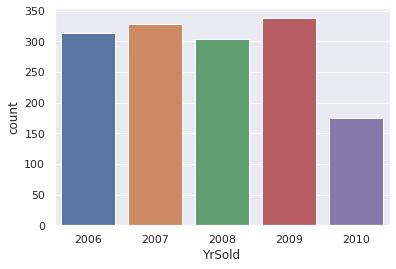

In [84]:
sns.countplot(x=df_train['YrSold'])

Вывод: эта информация могла бы иметь пользу, если бы распределени продаж было бы довольно большое(раньше дома могли стоить меньше и это надо было принимать во внимание), но в данной ситуации информацию о годе и месяце лучше откинуть

# Очистка данных от ненужных фич и создание простых

Тут я удаляю neighbourhood просто потому что не хочу много времени тратить наего анализ!!! Для дальнейшего улучшения модели его можно использовать

In [179]:


stay_columns = pd.Series(['OverallQual', 'Neighborhood', 'YearBuilt', 'ExterQual',
                 'BsmtQual', 'TotalBsmtSF', 'CentralAir', '1stFlrSF', '2ndFlrSF',
                 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageArea','SalePrice'])


df_test = df_test[df_test.columns.intersection(stay_columns)]
df_train = df_train[df_train.columns.intersection(stay_columns)]

for df in [df_train, df_test]:
    df['HouseSF'] = df['1stFlrSF'] + df['2ndFlrSF']
    df.drop(['1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

<ipython-input-179-9bc5e787ecd7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HouseSF'] = df['1stFlrSF'] + df['2ndFlrSF']
/home/vsevolod/anaconda3/envs/main/lib/python3.9/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Приколы со skew

In [182]:
data_numeric = df_train._get_numeric_data()

In [185]:
data_numeric.apply(lambda x: x.dropna().skew()).sort_values(ascending=False)

SalePrice      1.882876
TotalBsmtSF    1.524255
HouseSF        1.330470
ExterQual      0.825988
KitchenQual    0.386765
OverallQual    0.216944
GarageArea     0.179981
FireplaceQu    0.112770
YearBuilt     -0.613461
BsmtQual      -1.287571
CentralAir    -3.530386
dtype: float64

## Используем one_hot_encoding для Neighborhood и GarageFinish

In [171]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Убираем nan

## Для df_test

In [50]:
df_test.isna().sum(axis=0)

OverallQual             0
YearBuilt               0
ExterQual               0
BsmtQual                0
TotalBsmtSF             0
CentralAir              0
KitchenQual             0
FireplaceQu             0
GarageArea              0
HouseSF                 0
Neighborhood_Blmngtn    0
Neighborhood_Blueste    0
Neighborhood_BrDale     0
Neighborhood_BrkSide    0
Neighborhood_ClearCr    0
Neighborhood_CollgCr    0
Neighborhood_Crawfor    0
Neighborhood_Edwards    0
Neighborhood_Gilbert    0
Neighborhood_IDOTRR     0
Neighborhood_MeadowV    0
Neighborhood_Mitchel    0
Neighborhood_NAmes      0
Neighborhood_NPkVill    0
Neighborhood_NWAmes     0
Neighborhood_NoRidge    0
Neighborhood_NridgHt    0
Neighborhood_OldTown    0
Neighborhood_SWISU      0
Neighborhood_Sawyer     0
Neighborhood_SawyerW    0
Neighborhood_Somerst    0
Neighborhood_StoneBr    0
Neighborhood_Timber     0
Neighborhood_Veenker    0
GarageFinish_0          0
GarageFinish_Fin        0
GarageFinish_RFn        0
GarageFinish

In [51]:
median_to_fill_na = df_test[['TotalBsmtSF', 'GarageArea']].median()
df_test.fillna(median_to_fill_na, inplace=True)

## Для df_train

In [52]:
df_train.isna().sum(axis=0)

OverallQual             0
YearBuilt               0
ExterQual               0
BsmtQual                0
TotalBsmtSF             0
CentralAir              0
KitchenQual             0
FireplaceQu             0
GarageArea              0
SalePrice               0
HouseSF                 0
Neighborhood_Blmngtn    0
Neighborhood_Blueste    0
Neighborhood_BrDale     0
Neighborhood_BrkSide    0
Neighborhood_ClearCr    0
Neighborhood_CollgCr    0
Neighborhood_Crawfor    0
Neighborhood_Edwards    0
Neighborhood_Gilbert    0
Neighborhood_IDOTRR     0
Neighborhood_MeadowV    0
Neighborhood_Mitchel    0
Neighborhood_NAmes      0
Neighborhood_NPkVill    0
Neighborhood_NWAmes     0
Neighborhood_NoRidge    0
Neighborhood_NridgHt    0
Neighborhood_OldTown    0
Neighborhood_SWISU      0
Neighborhood_Sawyer     0
Neighborhood_SawyerW    0
Neighborhood_Somerst    0
Neighborhood_StoneBr    0
Neighborhood_Timber     0
Neighborhood_Veenker    0
GarageFinish_0          0
GarageFinish_Fin        0
GarageFinish

# Примитивная модель на отобранных фичах

## Ridge

In [160]:
df_model = df_train

X_train, X_test, y_train, y_test = house_data_split(df_model, 0.8)

ridge_grid.fit(X_train, y_train)
result =  ridge_grid.cv_results_
result = pd.DataFrame(result)
result.sort_values(by='rank_test_score', inplace=True)
result['mean_test_score'] = np.sqrt(-result['mean_test_score'])
result[['param_estimator__alpha', 'param_estimator__fit_intercept','mean_test_score']]

,param_estimator__alpha,param_estimator__fit_intercept,mean_test_score
18,100,True,0.157192
16,80,True,0.157240
14,40,True,0.157507
12,16,True,0.157816
10,8,True,0.157951
8,4,True,0.158027
6,2,True,0.158066
4,1,True,0.158087
2,0.5,True,0.158097
0,0.05,True,0.158106


RMSE on test data: 0


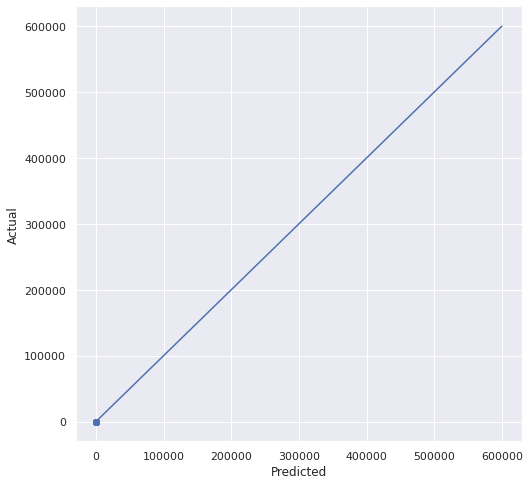

In [162]:
predicted = ridge_grid.predict(X_test)
rmse = round(np.sqrt(mean_squared_error(y_test, predicted)))
print(f'RMSE on test data: {rmse}')
plt.figure(figsize=(8, 8))
plt.scatter(predicted, y_test, alpha=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
min_max = [0, 600000]
plt.plot(min_max, min_max);

Вывод: наша модель стала лучше по сравнению с исходной(до отбрасывания фич), но RMSE портят 4-5 точек. Рассмотрим их

In [57]:
abs_distance = np.abs(y_test  - predicted).sort_values(ascending=False)
abs_distance

898     244801.925414
1046    187862.114740
440     173964.839599
688     136487.074470
1181    121974.535342
            ...      
869        502.400392
500        374.632347
382        199.258889
606         93.294979
83          92.149107
Name: SalePrice, Length: 292, dtype: float64

In [58]:
df_model.loc[abs_distance.index[:3], :]

,OverallQual,YearBuilt,ExterQual,BsmtQual,TotalBsmtSF,CentralAir,KitchenQual,FireplaceQu,GarageArea,SalePrice,...,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,GarageFinish_0,GarageFinish_Fin,GarageFinish_RFn,GarageFinish_Unf
898,9,2009,5,5,2330,1,5,4,820,611657,...,0,0,0,0,0,0,0,1,0,0
1046,9,2005,4,5,1992,1,5,4,716,556581,...,0,0,0,1,0,0,0,1,0,0
440,10,2008,5,5,3094,1,5,4,672,555000,...,0,0,0,0,0,0,0,1,0,0


In [59]:
df_unchanged_train.iloc[abs_distance.index[:3], :]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000


ind 1182 выглядит как outlier (тоже самое и для 632, 527)

Надо попробовать исключить outliers при помощи просмотра результатов регрессии на всех тестовых данных

## RandomForest

In [60]:
random_forest_pipe = Pipeline([('estimator', RandomForestRegressor())])
random_forest_parameters = {'estimator__n_estimators' : [50, 100, 200]}
random_forest_grid = GridSearchCV(random_forest_pipe, random_forest_parameters,
                          cv=10, scoring='neg_mean_squared_error')

In [61]:
random_forest_grid.fit(X_train, y_train)
get_grid_trainig_result(random_forest_grid.cv_results_)[['param_estimator__n_estimators',
                                                         'mean_test_score']]

,param_estimator__n_estimators,mean_test_score
0,50,32842.721190
1,100,33221.002356
2,200,33744.397918


rmse: 30452


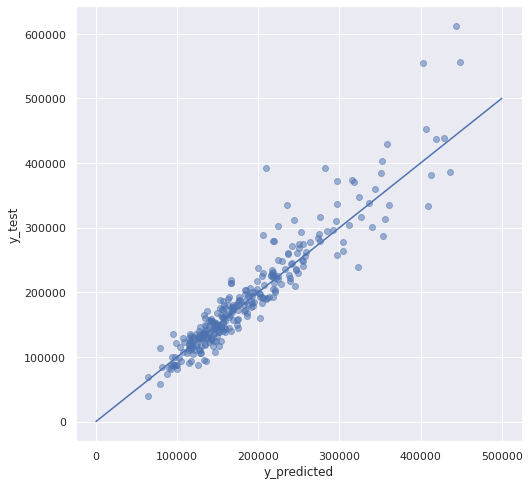

In [62]:
y_predicted = random_forest_grid.predict(X_test)
print(f'rmse: {get_rmse(y_predicted, y_test)}')
plot_prediction_result(y_predicted, y_test)

Вывод: существенных различий между лесами и регрессией нет, будем улучшать регрессию

# Подготовка к линейной регрессии

## SalePrice

In [122]:
def plot_norm(series: pd.Series, ax=None):
    if ax is None:
        ax = plt.gca()
    mu, std = stats.norm.fit(series)
    xmin = series.min() - 1 *std
    xmax= series.max() + 1 * std
    x = np.linspace(xmin, xmax, 100)
    y = stats.norm.pdf(x, mu, std)
    ax.plot(x, y, 'k', linewidth=2)
    plt.xlim([xmin, xmax])

In [133]:
def plot_compare_with_normal(series: pd.Series):
    sns.displot(series, stat="density", kde=True)
    plot_norm(series)
    fig = plt.figure()
    return stats.probplot(series, plot=plt)

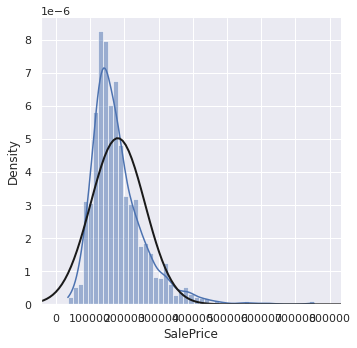

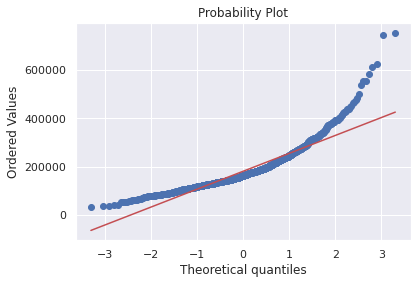

In [134]:
plot_compare_with_normal(df_train['SalePrice']);

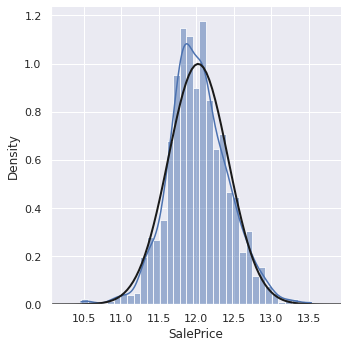

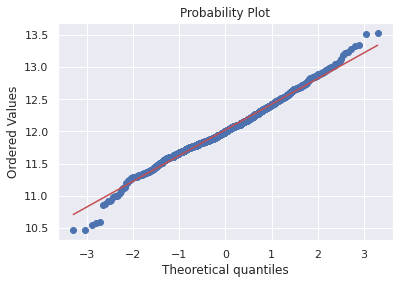

In [135]:
after_log = np.log(df_train['SalePrice'])
plot_compare_with_normal(after_log);

## OverallQual

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 1,  1,  2, ..., 10, 10, 10])),
 (1.3488027348168252, 6.0993150684931505, 0.9736657788215162))

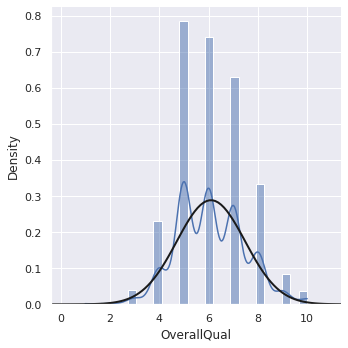

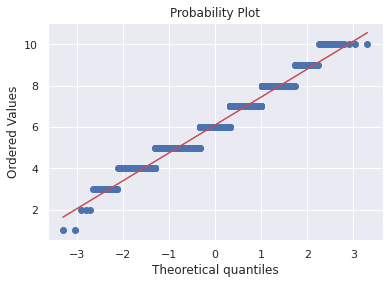

In [138]:
plot_compare_with_normal(df_train['OverallQual'])

# TODO

1. Нельзя просто удалять стоблцы в тестовых данных из-за nanов
2. Пересмотреть столбцы которые мы оставляем!
3. Забить на создание новых фич и попробовать нормолизировать все переменные, а затем применить линейную модель